In [ ]:
#Bonus 1

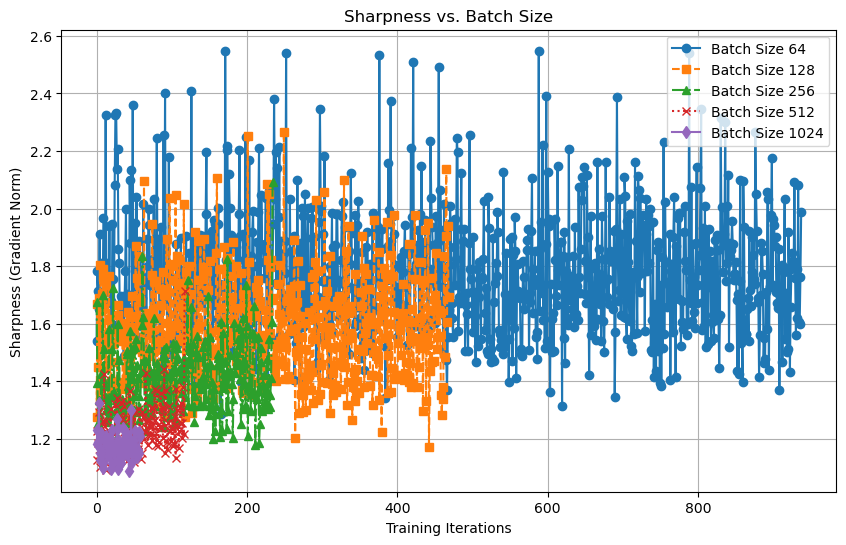

In [2]:
import torch
import torch.nn as nn  # Make sure to import torch.nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to compute gradient norm for a given model and data loader
def compute_gradient_norm(model, data_loader):
    criterion = nn.CrossEntropyLoss()
    gradient_norms = []

    for inputs, labels in data_loader:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Create a new optimizer for each batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Compute gradients
        gradients = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        gradient_norm = torch.sqrt(sum(torch.sum(grad**2) for grad in gradients))
        gradient_norms.append(gradient_norm.item())

    return gradient_norms

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Set up data loaders for different batch sizes
batch_sizes = [64, 128, 256, 512, 1024]  # Add more batch sizes if needed
gradient_norms_list = []

for batch_size in batch_sizes:
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

    # Define the model and optimizer
    model = SimpleNN()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train the model
    gradient_norms = compute_gradient_norm(model, train_loader)
    gradient_norms_list.append(gradient_norms)

# Plot sharpness (gradient norm) vs. batch size
plt.figure(figsize=(10, 6))

# Define plot markers and line styles for different batch sizes
markers = ['o', 's', '^', 'x', 'd']
line_styles = ['-', '--', '-.', ':', '-']

for i, batch_size in enumerate(batch_sizes):
    plt.plot(gradient_norms_list[i], label=f'Batch Size {batch_size}', marker=markers[i], linestyle=line_styles[i], markersize=6)

plt.xlabel('Training Iterations')
plt.ylabel('Sharpness (Gradient Norm)')
plt.title('Sharpness vs. Batch Size')
plt.legend()
plt.grid(True)  # Add grid for better visualization
plt.show()


In [ ]:
#bonus 2

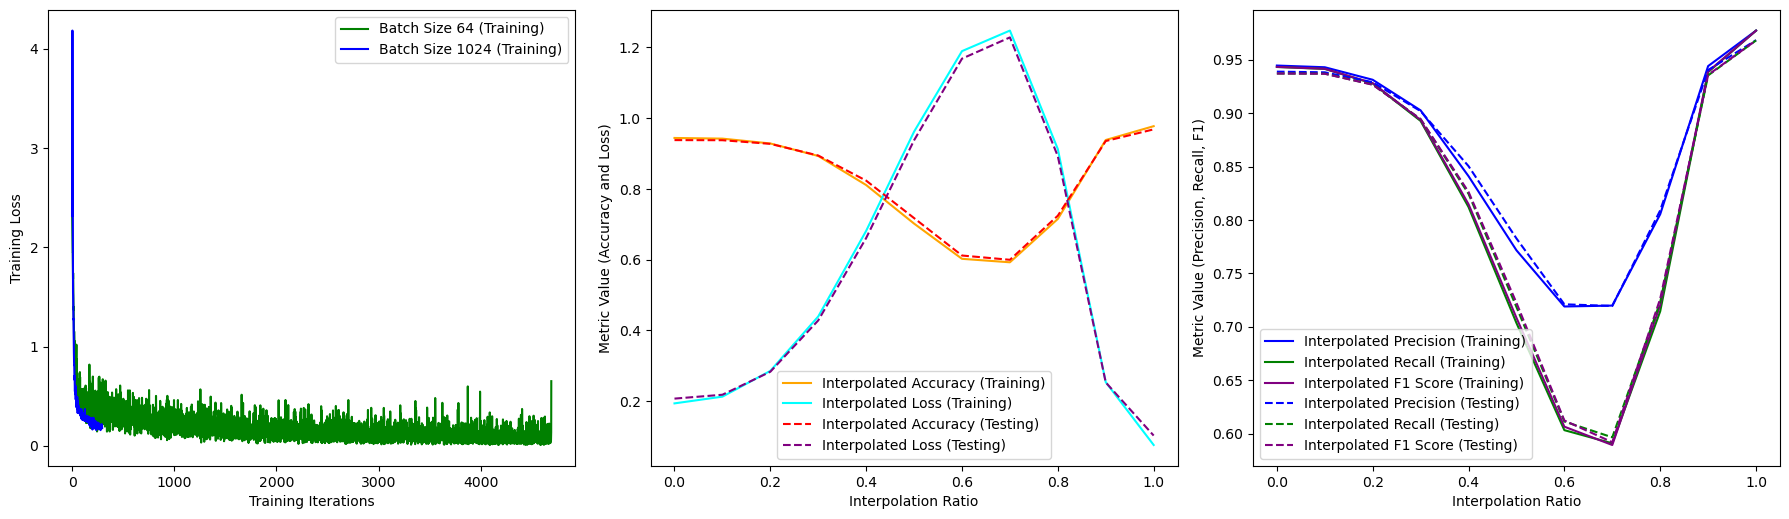

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

torch.manual_seed(1)

# Define the neural network architecture (same as before)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train a model
def train_model(model, loader, loss_func, optimizer, epochs=5):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        for inputs, labels in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
    return train_losses

# Function to evaluate a model on a dataset
def evaluate_model(model, data_loader, loss_func):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            total_loss += loss_func(outputs, labels).item()
    accuracy = correct_predictions / total_samples
    return accuracy, total_loss / len(data_loader)

# Function to calculate precision, recall, and F1 score
def evaluate_model_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    return precision, recall, f1

# Linear interpolation function
def linear_interpolation(model1, model2, alpha):
    interpolated_model = SimpleNN()
    new_state_dict = {}
    for key in model1.state_dict():
        new_state_dict[key] = alpha * model1.state_dict()[key] + (1 - alpha) * model2.state_dict()[key]
    interpolated_model.load_state_dict(new_state_dict)
    return interpolated_model

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Set up data loaders
batch_size_small = 64
batch_size_large = 1024
train_loader_small = DataLoader(mnist_train, batch_size=batch_size_small, shuffle=True)
train_loader_large = DataLoader(mnist_train, batch_size=batch_size_large, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

# Define models
model_small_batch = SimpleNN()
model_large_batch = SimpleNN()

# Define loss function and optimizers
loss_func = nn.CrossEntropyLoss()
optimizer_small = optim.Adam(model_small_batch.parameters(), lr=1e-3)
optimizer_large = optim.Adam(model_large_batch.parameters(), lr=1e-2)

# Train the models
train_loss_small = train_model(model_small_batch, train_loader_small, loss_func, optimizer_small)
train_loss_large = train_model(model_large_batch, train_loader_large, loss_func, optimizer_large)

# Evaluate models
accuracy_small, _ = evaluate_model(model_small_batch, test_loader, loss_func)
accuracy_large, _ = evaluate_model(model_large_batch, test_loader, loss_func)

# Linear interpolation and evaluation for different interpolation ratios
alphas = torch.linspace(0, 1, 11)
interp_accuracies_train = []
interp_losses_train = []
interp_accuracies_test = []
interp_losses_test = []

interp_precisions_train = []
interp_recalls_train = []
interp_f1_scores_train = []

interp_precisions_test = []
interp_recalls_test = []
interp_f1_scores_test = []

for alpha in alphas:
    interp_model = linear_interpolation(model_small_batch, model_large_batch, alpha)
    
    # Evaluate on training set
    accuracy_train, loss_train = evaluate_model(interp_model, train_loader_small, loss_func)
    precision_train, recall_train, f1_train = evaluate_model_metrics(interp_model, train_loader_small)
    
    # Evaluate on test set
    accuracy_test, loss_test = evaluate_model(interp_model, test_loader, loss_func)
    precision_test, recall_test, f1_test = evaluate_model_metrics(interp_model, test_loader)
    
    # Store the metrics
    interp_accuracies_train.append(accuracy_train)
    interp_losses_train.append(loss_train)
    interp_precisions_train.append(precision_train)
    interp_recalls_train.append(recall_train)
    interp_f1_scores_train.append(f1_train)

    interp_accuracies_test.append(accuracy_test)
    interp_losses_test.append(loss_test)
    interp_precisions_test.append(precision_test)
    interp_recalls_test.append(recall_test)
    interp_f1_scores_test.append(f1_test)

# Plotting
plt.figure(figsize=(18, 10))

# Plot training loss
plt.subplot(2, 3, 1)
plt.plot(train_loss_small, color='green', label='Batch Size 64 (Training)')
plt.plot(train_loss_large, color='blue', label='Batch Size 1024 (Training)')
plt.xlabel('Training Iterations')
plt.ylabel('Training Loss')
plt.legend()

# Plot interpolated accuracy and loss (training and testing)
plt.subplot(2, 3, 2)
plt.plot(alphas.numpy(), interp_accuracies_train, color='orange', label='Interpolated Accuracy (Training)')
plt.plot(alphas.numpy(), interp_losses_train, color='cyan', label='Interpolated Loss (Training)')
plt.plot(alphas.numpy(), interp_accuracies_test, color='red', linestyle='--', label='Interpolated Accuracy (Testing)')
plt.plot(alphas.numpy(), interp_losses_test, color='purple', linestyle='--', label='Interpolated Loss (Testing)')
plt.xlabel('Interpolation Ratio')
plt.ylabel('Metric Value (Accuracy and Loss)')
plt.legend()

# Plot interpolated precision, recall, and F1 score (training and testing)
plt.subplot(2, 3, 3)
plt.plot(alphas.numpy(), interp_precisions_train, color='blue', label='Interpolated Precision (Training)')
plt.plot(alphas.numpy(), interp_recalls_train, color='green', label='Interpolated Recall (Training)')
plt.plot(alphas.numpy(), interp_f1_scores_train, color='purple', label='Interpolated F1 Score (Training)')
plt.plot(alphas.numpy(), interp_precisions_test, color='blue', linestyle='--', label='Interpolated Precision (Testing)')
plt.plot(alphas.numpy(), interp_recalls_test, color='green', linestyle='--', label='Interpolated Recall (Testing)')
plt.plot(alphas.numpy(), interp_f1_scores_test, color='purple', linestyle='--', label='Interpolated F1 Score (Testing)')
plt.xlabel('Interpolation Ratio')
plt.ylabel('Metric Value (Precision, Recall, F1)')
plt.legend()

plt.tight_layout()
plt.show()
